# Convolutional Neural Network

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from io import open

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Run the pip install command below in the notebook. This will install the tf_slim code repository that will be used to use the Inception model. The code in the following cell command can be commented out and skipped if tf_slim repository is pip installed through the terminal with the command 
`pip install --upgrade tf_slim`

In [2]:
# tf-slim pip installation
!pip3 install --upgrade tf_slim

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


A couple utility functions to plot grayscale and RGB images:

In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

And of course we will need TensorFlow:

In [63]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

print(tf.__version__)

2.16.1


# Convolutional layer

In [5]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

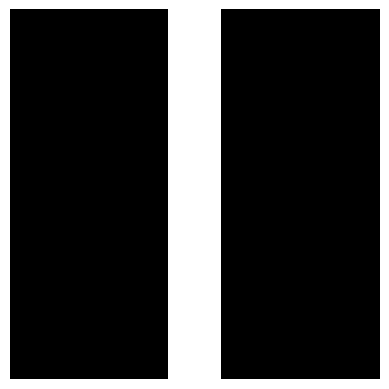

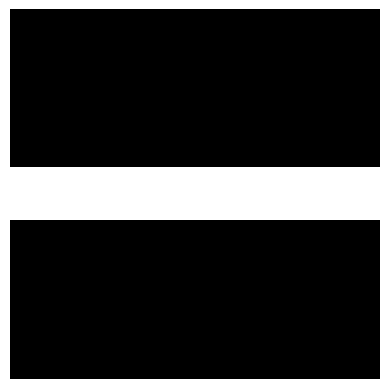

In [6]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

We've simulated the results of applying these two kinds of filters to the image in write-up question 3, now it's time to apply it on real image and validate your answer.

In [25]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
# TODO :: Apply feature_maps to input image X with tf.nn.conv2d (i.e. tensorflow.compat.v1.nn.conv2d), the strides 
# is 1 for each dimension of input. Expect 1 line of code
convolution = tf.nn.conv2d(X, feature_maps, strides=[1, 1, 1, 1], padding='SAME')


In [26]:
# TODO :: create a session and evaluate the convolution operation a
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output = sess.run(convolution, feed_dict={X: images})

In [27]:
output.shape

(1, 70, 120, 2)

Saving figure china_original


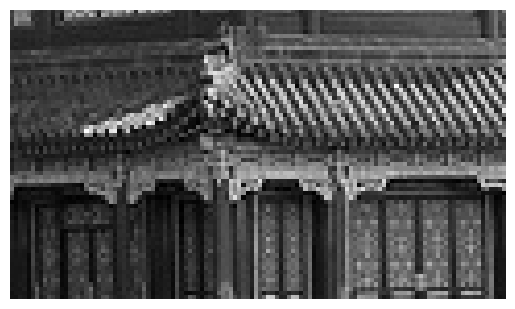

In [28]:
plot_image(images[0, :, :, 0])
save_fig("china_original", tight_layout=False)
plt.show()

Saving figure china_vertical


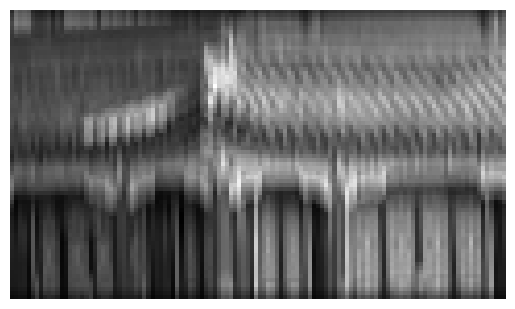

In [29]:
plot_image(output[0, :, :, 0])
save_fig("china_vertical", tight_layout=False)
plt.show()

Saving figure china_horizontal


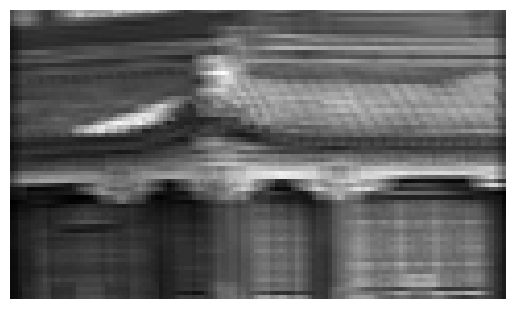

In [30]:
plot_image(output[0, :, :, 1])
save_fig("china_horizontal", tight_layout=False)
plt.show()

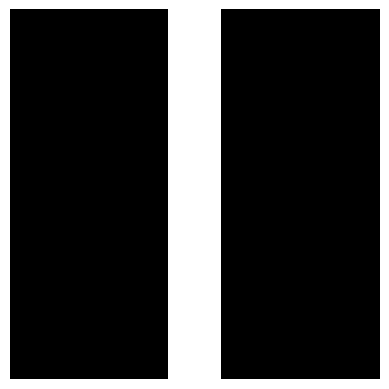

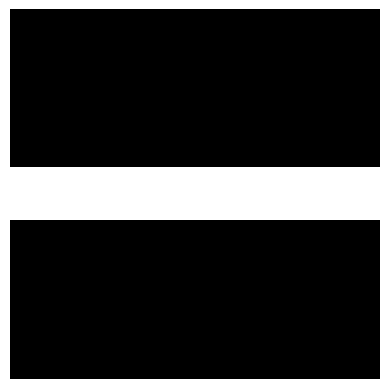

In [57]:
reset_graph()

# TODO :: Can you build two filters that can sharpen and blur an image respectively. Test your feature by applying
# it on the china.jpg. Expect 3 lines of code.
sharpen_filter = np.array([[[[0], [-1], [0]], [[-1], [5], [-1]], [[0], [-1], [0]]],
                           [[[-1], [5], [-1]], [[5], [-25], [5]], [[-1], [5], [-1]]],
                           [[[0], [-1], [0]], [[-1], [5], [-1]], [[0], [-1], [0]]]],
                          dtype=np.float32)
blur_filter = np.ones((3, 3, 3, 1), dtype=np.float32) / 27

china = load_sample_image("china.jpg").astype(np.float32)
china /= 255.0  # normalize
china_batch = china[np.newaxis]  # batch 

# input image
X = tf.placeholder(tf.float32, shape=china_batch.shape)

# convolution
sharpened = tf.nn.conv2d(X, sharpen_filter, strides=[1, 1, 1, 1], padding="SAME")
blurred = tf.nn.conv2d(X, blur_filter, strides=[1, 1, 1, 1], padding="SAME")

# transform image session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    china_sharpened, china_blurred = sess.run([sharpened, blurred], feed_dict={X: china_batch})

plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [49]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Saving figure china_sharpen


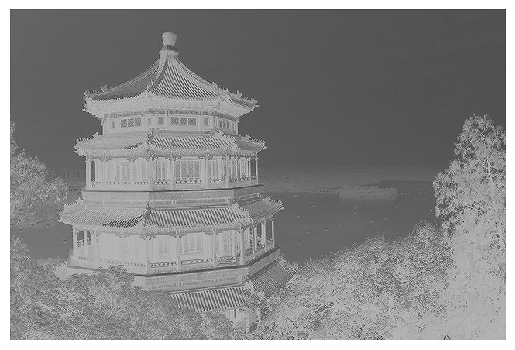

In [54]:
plot_image(china_sharpened[0, :, :, 0])
save_fig("china_sharpen", tight_layout=False)
plt.show()

Saving figure china_blurred


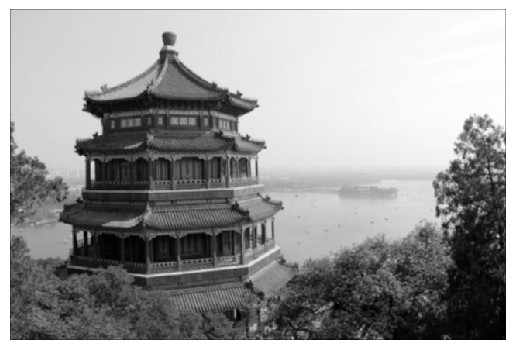

In [56]:
plot_image(china_blurred[0, :, :, 0])
save_fig("china_blurred", tight_layout=False)
plt.show()

## VALID vs SAME padding

In [58]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))

valid_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1, 1, 5, 1], padding='SAME')

with tf.Session() as sess:
    print("VALID:\n", valid_conv.eval())
    print("SAME:\n", same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


# Pooling layer

In [59]:
import numpy as np
from sklearn.datasets import load_sample_images

# Load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

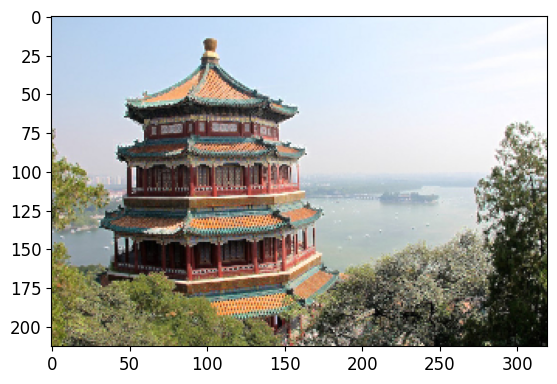

In [60]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

Saving figure china_original


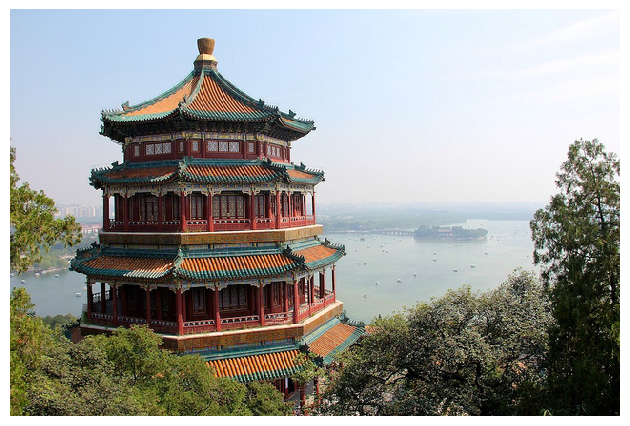

Saving figure china_max_pool


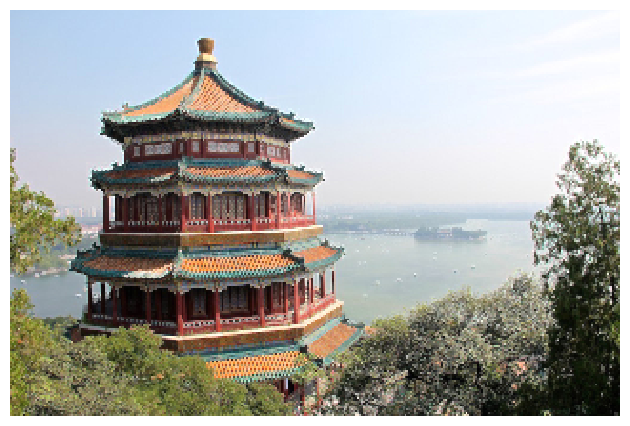

In [61]:
plot_color_image(dataset[0])
save_fig("china_original")
plt.show()
    
plot_color_image(output[0])
save_fig("china_max_pool")
plt.show()

# MNIST

Note: for readability we will be referring to the functions below with tf where tf represents the tensorflow 1.x functionality
of `tf.compat.v1`. Therefore, when we refer to the `tf.layers.conv2d()`, we are actually referring to the function 
`tf.compat.v1.layers.conv2d()`.


For all these functions:
* the `scope` parameter was renamed to `name`, and the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).

The other main differences in `tf.layers.dense()` are:
* the `weights` parameter was renamed to `kernel` (and the weights variable is now named `"kernel"` rather than `"weights"`),
* the default activation is `None` instead of `tf.nn.relu`

The other main differences in `tf.layers.conv2d()` are:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the default `activation` is now `None` instead of `tf.nn.relu`.

The other main differences in `tf.layers.dropout()` are:
* it takes the dropout rate (`rate`) rather than the keep probability (`keep_prob`). Of course, `rate == 1 - keep_prob`,
* the `is_training` parameters was renamed to `training`.

In [83]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

# TOOD : build two convolution layers here, use the hyperparameters we defined earlier, use relu as activation function
# name them as "conv1" and "conv2" respectively. Expect 2 lines of code.
conv1 = tf.keras.layers.Conv2D(filters=conv1_fmaps, kernel_size=conv1_ksize,
                               strides=conv1_stride, padding=conv1_pad,
                               activation='relu', name="conv1")(X_reshaped)
conv2 = tf.keras.layers.Conv2D(filters=conv2_fmaps, kernel_size=conv2_ksize,
                               strides=conv2_stride, padding=conv2_pad,
                               activation='relu', name="conv2")(conv1)
# conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
#                          strides=conv1_stride, padding=conv1_pad,
#                          activation=tf.nn.relu, name="conv1")
# conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
#                          strides=conv2_stride, padding=conv2_pad,
#                          activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    # TODO : define max pooling layer here, the kernel size is 2 * 2, and the strides is 2 for both vertical and horizontal,
    # Use "VALID" as padding method (remember to flatten the pooling result), expect 2 lines of code.
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
    # print("...") # placeholder to avoid Python syntax errors
 

with tf.name_scope("fc1"):
    # TODO : define a fully connected layer for flattened pooling result. Namse it as "fc1", expect 1 line of code.
    fc1 = tf.keras.layers.Dense(n_fc1, activation='relu', name='fc1')(pool3_flat)
    # print("...") # placeholder to avoid Python syntax errors
    

with tf.name_scope("output"):
    # TODO : define the output layer and the result goes into softmax layer to get the prediction probability.
    # name the output layer as "output", name the softmax layer as "Y_proba", expect 2 lines of code.
    logits = tf.keras.layers.Dense(n_outputs, name='output')(fc1)
    Y_proba = tf.nn.softmax(logits, name='Y_proba')
    # print("...") # placeholder to avoid Python syntax errors
    
    
with tf.name_scope("train"):
    # TODO : define a loss function with sparse_softmax_cross_entropy_with_logits, and optimize the loss with AdamOptimizer
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    # print("...") # placeholder to avoid Python syntax errors
    

with tf.name_scope("eval"):
    # TODO : define the accuracy of the model with tf.reduce_mean, you may want to use tf.nn.in_top_k , expect 2 lines of the code
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    # print("...") # placeholder to avoid Python syntax errors

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead.

In [75]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [76]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [84]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9778
1 Last batch accuracy: 0.97 Test accuracy: 0.9839
2 Last batch accuracy: 0.99 Test accuracy: 0.9827
3 Last batch accuracy: 0.98 Test accuracy: 0.9881
4 Last batch accuracy: 0.99 Test accuracy: 0.9906
5 Last batch accuracy: 0.99 Test accuracy: 0.9895
6 Last batch accuracy: 1.0 Test accuracy: 0.9883
7 Last batch accuracy: 1.0 Test accuracy: 0.9878
8 Last batch accuracy: 1.0 Test accuracy: 0.9905
9 Last batch accuracy: 1.0 Test accuracy: 0.989


## Add Dropout Layer to CNN

In this exercise, you are asked to modify the CNN we defined earlier, stride 1 for the second convolutional layer (rather than 2), with 25% dropout after the second convolutional layer, 50% dropout after the fully connected layer, and trained using early stopping. The accuracy should be around 99.2% on MNIST.

In [90]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = "SAME"
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    training = tf.placeholder_with_default(False, shape=[], name='training')

conv1 = tf.keras.layers.Conv2D(filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")(X_reshaped)
conv2 = tf.keras.layers.Conv2D(filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")(conv1)

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 14 * 14])
    pool3_flat_drop = tf.keras.layers.Dropout(conv2_dropout_rate)(pool3_flat)

with tf.name_scope("fc1"):
    fc1 = tf.keras.layers.Dense(n_fc1, activation=tf.nn.relu, name="fc1")(pool3_flat_drop)
    fc1_drop = tf.keras.layers.Dropout(fc1_dropout_rate)(fc1)

with tf.name_scope("output"):
    logits = tf.keras.layers.Dense(n_outputs, name="output")(fc1_drop)
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

The `get_model_params()` function gets the model's state (i.e., the value of all the variables), and the `restore_model_params()` restores a previous state. This is used to speed up early stopping: instead of storing the best model found so far to disk, we just save it to memory. At the end of training, we roll back to the best model found.

In [91]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

Now let's train the model! This implementation of Early Stopping works like this:
* every 100 training iterations, it evaluates the model on the validation set,
* if the model performs better than the best model found so far, then it saves the model to RAM,
* if there is no progress for 100 evaluations in a row, then training is interrupted,
* after training, the code restores the best model found.

In [92]:
n_epochs = 1000
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            iteration += 1
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print("Epoch {}, last batch accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!")
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print("Final accuracy on test set:", acc_test)
    save_path = saver.save(sess, "./my_mnist_model")

Epoch 0, last batch accuracy: 100.0000%, valid. accuracy: 98.2200%, valid. best loss: 0.060479
Epoch 1, last batch accuracy: 100.0000%, valid. accuracy: 98.7400%, valid. best loss: 0.048419
Epoch 2, last batch accuracy: 100.0000%, valid. accuracy: 98.3800%, valid. best loss: 0.047402
Epoch 3, last batch accuracy: 100.0000%, valid. accuracy: 98.9400%, valid. best loss: 0.041106
Epoch 4, last batch accuracy: 100.0000%, valid. accuracy: 99.0400%, valid. best loss: 0.038156
Epoch 5, last batch accuracy: 100.0000%, valid. accuracy: 98.7200%, valid. best loss: 0.038156
Epoch 6, last batch accuracy: 100.0000%, valid. accuracy: 99.1200%, valid. best loss: 0.038156
Epoch 7, last batch accuracy: 100.0000%, valid. accuracy: 98.8400%, valid. best loss: 0.038156
Epoch 8, last batch accuracy: 100.0000%, valid. accuracy: 98.9000%, valid. best loss: 0.038156
Epoch 9, last batch accuracy: 100.0000%, valid. accuracy: 98.9000%, valid. best loss: 0.038156
Epoch 10, last batch accuracy: 100.0000%, valid. a

# Classifying large images using Inception v3.


In [93]:
width = 299
height = 299
channels = 3

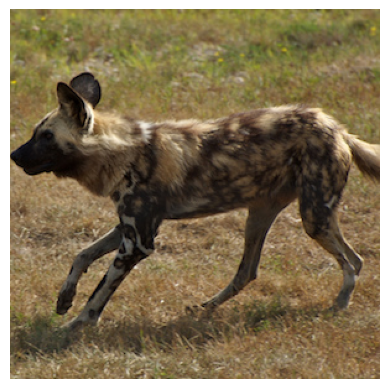

In [94]:
import matplotlib.image as mpimg
test_image = mpimg.imread(os.path.join("images","cnn","test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [95]:
# Ensure that the values are in the range [-1, 1] (as expected by the pretrained Inception model), instead of [0, 1]:
test_image = 2 * test_image - 1

Download the latest pretrained Inception v3 model: the checkpoint is available at https://github.com/tensorflow/models/tree/master/research/slim. The list of class names is available at https://goo.gl/brXRtZ, we have to insert a "background" class at the beginning.

<div class="alert alert-warning">THE SPECIFIED PRE-TRAINED INCEPTION_V3 MODEL DOES NOT WORK, TENSORFLOW HAS BEEN UPDATED AND THIS MODEL IS RUNNING DEPRECIATED TENSORFLOW SYNTEX</div>

In [161]:
import sys
import tarfile
from six.moves import urllib
!pip3 install --upgrade tensorflow<=2.10

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")


def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

zsh:1: 2.10 not found


In [162]:
fetch_pretrained_inception_v3()

In [163]:
import re

CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

def load_class_names():
    path = os.path.join("datasets", "imagenet_class_names.txt")
    with open(path, encoding="utf-8") as f:
        content = f.read()
        return CLASS_NAME_REGEX.findall(content)

In [164]:
class_names = ["background"] + load_class_names()

In [165]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

In [166]:
from tf_slim.nets import inception
import tf_slim as slim

In [167]:
reset_graph()


X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


ModuleNotFoundError: No module named 'tf_keras'

In [106]:
# Create a session and use the saver to restore the pretrained model. 
# Run the model to classify the images you prepared. Display the top five predictions for each image, 
# along with the estimated probability (the list of class names is available at https://goo.gl/brXRtZ). 

X_test = test_image.reshape(-1, height, width, channels)

with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


TypeError: Cannot interpret feed_dict key as Tensor: The name 'init_and_save/save/Const:0' refers to a Tensor which does not exist. The operation, 'init_and_save/save/Const', does not exist in the graph.

In [107]:
most_likely_class_index = np.argmax(predictions_val[0])
most_likely_class_index

NameError: name 'predictions_val' is not defined

In [108]:
class_names[most_likely_class_index]

NameError: name 'most_likely_class_index' is not defined

In [109]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

NameError: name 'predictions_val' is not defined

The model is quite accurate on this particular image: if makes the right prediction with high confidence.

## Transfer learning for large image classification.


Let's tackle the flowers dataset. First, we need to download it:

In [110]:
import sys
import tarfile
from six.moves import urllib

FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flower_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [111]:
# Calling this function may cause IOPub message rate exceeded messages. If you want to remove these messages, then follow the
# instructions given. However, the messages should not effect the codes correctness. 
fetch_flowers()

Downloading: 100%

Each subdirectory of the `flower_photos` directory contains all the pictures of a given class. Let's get the list of classes:

In [112]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

Let's get the list of all the image file paths for each class:

In [113]:
from collections import defaultdict

image_paths = defaultdict(list)

for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

Let's sort the image paths just to make this notebook behave consistently across multiple runs:

In [114]:
for paths in image_paths.values():
    paths.sort()

Let's take a peek at the first few images from each class:

Class: daisy


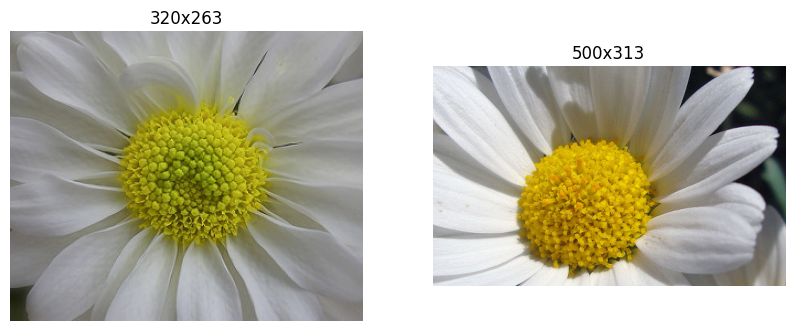

Class: dandelion


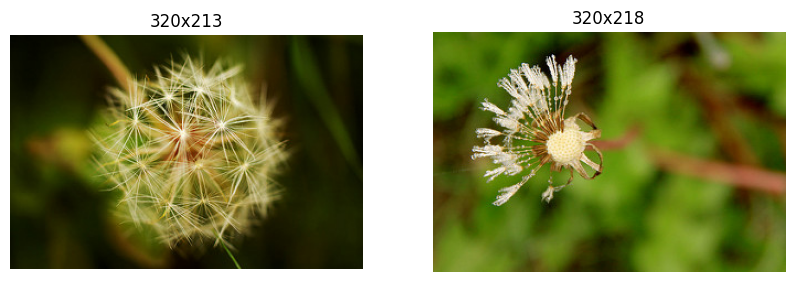

Class: roses


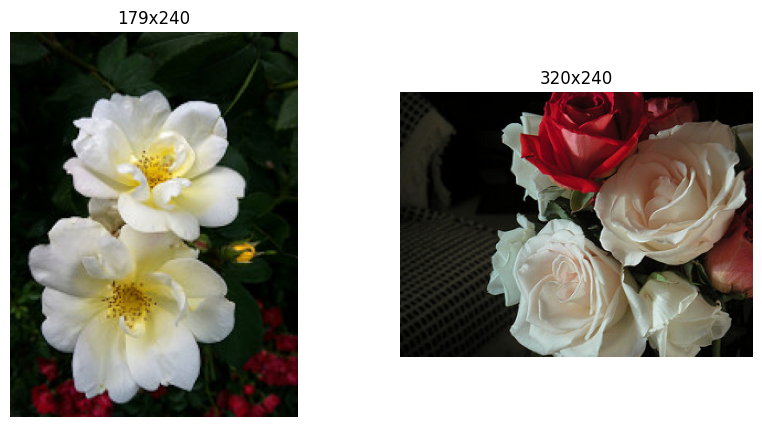

Class: sunflowers


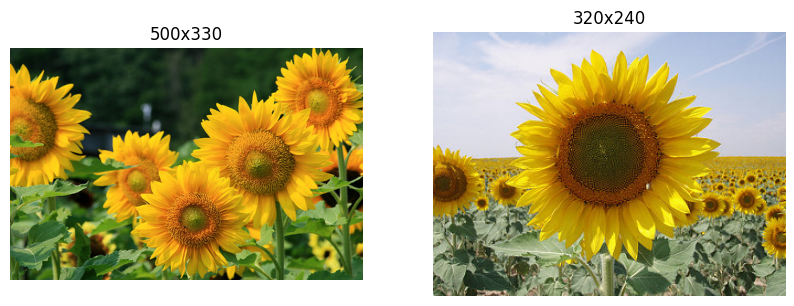

Class: tulips


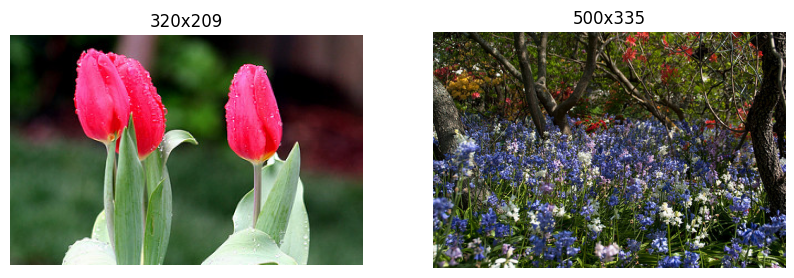

In [115]:
import matplotlib.image as mpimg

n_examples_per_class = 2

for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

Notice how the image dimensions vary, and how difficult the task is in some cases (e.g., the 2nd tulip image).

Write a preprocessing step that will resize and crop the image to 299 × 299, with some randomness for data augmentation.


First, let's implement this using NumPy and SciPy:

* using basic NumPy slicing for image cropping,
* NumPy's `fliplr()` function to flip the image horizontally (with 50% probability),
* and SciPy's `imresize()` function for zooming.
  * Note that `imresize()` is based on the Python Image Library (PIL).

For more image manipulation functions, such as rotations, check out [SciPy's documentation](https://docs.scipy.org/doc/scipy-0.19.0/reference/ndimage.html) or [this nice page](http://www.scipy-lectures.org/advanced/image_processing/).

In [118]:
# !pip3 install scikit-image
from skimage.transform import resize

def prepare_image(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height
        
    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next, we can select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    # The resize function of scikit-image will automatically transform the image to floats ranging from 0.0 to 1.0
    image = resize(image, (target_width, target_height))
    
    # Finally, let's ensure that the colors are represented as 32-bit floats:
    return image.astype(np.float32)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 24.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 KB 42.9 MB/s eta 0:00:00
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


Note: at test time, the preprocessing step should be as light as possible, just the bare minimum necessary to be able to feed the image to the neural network. You may want to tweak the above function to add a `training` parameter: if `False`, preprocessing should be limited to the bare minimum (i.e., no flipping the image, and just the minimum cropping required, preserving the center of the image).

Let's check out the result on this image:

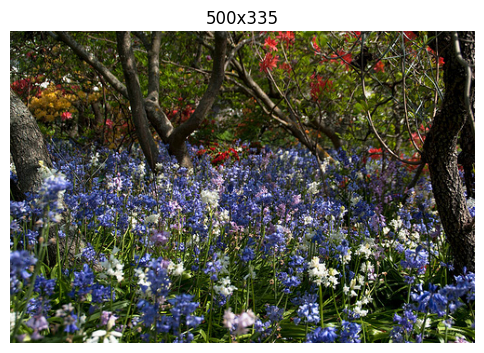

In [119]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

There we go:

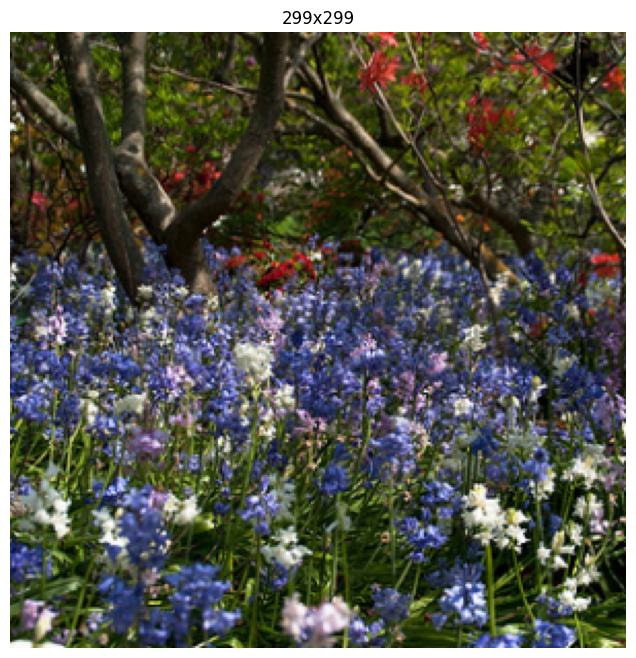

In [120]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Now let's look at a few other random images generated from the same original image:

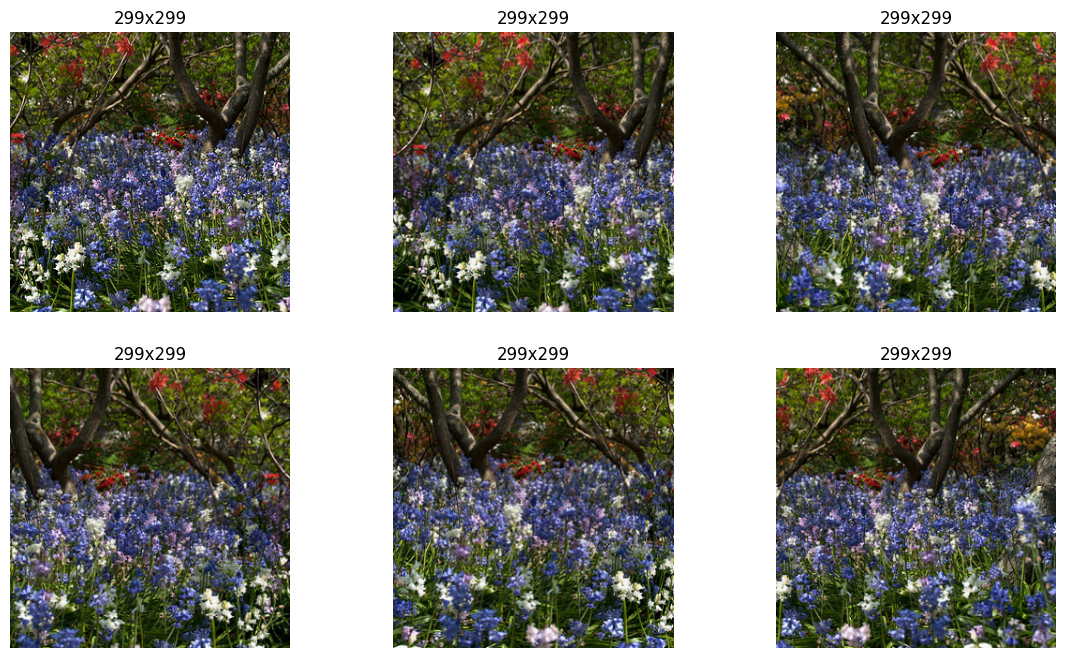

In [121]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

Looks good!

Alternatively, it's also possible to implement this image preprocessing step directly with TensorFlow, using the functions in the `tf.image` module (see [the API](https://www.tensorflow.org/api_docs/python/) for the full list). As you can see, this function looks very much like the one above, except it does not actually perform the image transformation, but rather creates a set of TensorFlow operations that *will* perform the transformation when you run the graph.

In [122]:
def prepare_image_with_tensorflow(image, target_width = 299, target_height = 299, max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], minval=1.0, maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])   # 3 = number of channels

    # Let's crop the image using a random bounding box of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a 4D tensor (a batch of images)
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. Note that this function
    # returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, [target_height, target_width])
    image = image_batch[0] / 255  # back to a single image, and scale the colors from 0.0 to 1.0
    return image

Let's test this function!

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.


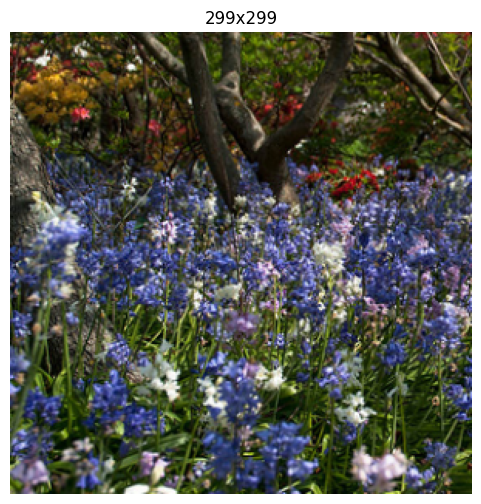

In [123]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(feed_dict={input_image: example_image})
    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

Looks perfect!

Next we will using the pretrained Inception v3 model from the previous exercise, freeze all layers up to the bottleneck layer (i.e., the last layer before the output layer), and replace the output layer with the appropriate number of outputs for your new classification task (e.g., the flowers dataset has five mutually exclusive classes so the output layer must have five neurons and use the softmax activation function).


Let's start by fetching the inception v3 graph again. This time, let's use a `training` placeholder that we will use to tell TensorFlow whether we are training the network or not (this is needed by operations such as dropout and batch normalization).

In [124]:
reset_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)

inception_saver = tf.train.Saver()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


ModuleNotFoundError: No module named 'tf_keras'

Now we need to find the point in the graph where we should attach the new output layer.  It should be the layer right before the current output layer. One way to do this is to explore the output layer's inputs:  

In [125]:
logits.op.inputs[0]

<tf.Tensor 'output/output_1/MatMul:0' shape=(?, 10) dtype=float32>

Nope, that's part of the output layer (adding the biases). Let's continue walking backwards in the graph:

In [126]:
logits.op.inputs[0].op.inputs[0]

<tf.Tensor 'fc1/fc1_1/Relu:0' shape=(?, 128) dtype=float32>

That's also part of the output layer, it's the final layer in the inception layer (if you are not sure you can visualize the graph using TensorBoard). Once again, let's continue walking backwards in the graph:

In [127]:
logits.op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'fc1/fc1_1/Add:0' shape=(?, 128) dtype=float32>

Aha! There we are, this is the output of the dropout layer. This is the very last layer before the output layer in the Inception v3 network, so that's the layer we need to build upon. Note that there was actually a simpler way to find this layer: the `inception_v3()` function returns a dict of end points: 

In [128]:
end_points

NameError: name 'end_points' is not defined

As you can see, the `"PreLogits"` end point is precisely what we need:

In [138]:
end_points["PreLogits"]

NameError: name 'end_points' is not defined

We can drop the 2nd and 3rd dimensions using the `tf.squeeze()` function:

In [139]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

NameError: name 'end_points' is not defined

Then we can add the final fully connected layer on top of this layer:

In [140]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

AttributeError: `dense` is not available with Keras 3.

Finally, we need to add the usual bits and pieces:

* the placeholder for the targets (`y`),
* the loss function, which is the cross-entropy, as usual for a classification task,
* an optimizer, that we use to create a training operation that will minimize the cost function,
* a couple operations to measure the model's accuracy,
* and finally an initializer and a saver.

There is one important detail, however: since we want to train only the output layer (all other layers must be frozen), we must pass the list of variables to train to the optimizer's `minimize()` method:

In [141]:
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver() 

NameError: name 'flower_logits' is not defined

In [142]:
[v.name for v in flower_vars]

NameError: name 'flower_vars' is not defined

Notice that we created the `inception_saver` before adding the new output layer: we will use this saver to restore the pretrained model state, so we don't want it to try to restore new variables (it would just fail saying it does not know the new variables). The second `saver` will be used to save the final flower model, including both the pretrained variables and the new ones.

Split your dataset into a training set and a test set. Train the model on the training set and evaluate it on the test set.


First, we will want to represent the classes as ints rather than strings:

In [143]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

It will be easier to shuffle the dataset set if we represent it as a list of filepath/class pairs:

In [144]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

Next, lets shuffle the dataset and split it into the training set and the test set:

In [145]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

Let's look at the first 3 instances in the training set:

In [146]:
flower_paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0),
 ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3),
 ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4)]

Next, we will also need a function to preprocess a set of images. This function will be useful to preprocess the test set, and also to create batches during training. For simplicity, we will use the NumPy/SciPy implementation:

In [147]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2 * np.stack(prepared_images) - 1 # Inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [148]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [149]:
X_batch.shape

(4, 299, 299, 3)

In [150]:
X_batch.dtype

dtype('float32')

In [151]:
y_batch.shape

(4,)

In [152]:
y_batch.dtype

dtype('int32')

Looking good. Now let's use this function to prepare the test set:

In [153]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [154]:
X_test.shape

(734, 299, 299, 3)

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

In [155]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [156]:
X_test.shape

(734, 299, 299, 3)

We could prepare the training set in much the same way, but it would only generate one variant for each image. Instead, it's preferable to generate the training batches on the fly during training, so that we can really benefit from data augmentation, with many variants of each image.

And now, we are ready to train the network (or more precisely, the output layer we just added, since all the other layers are frozen). Be aware that this may take a (very) long time.

<div class="alert alert-warning">THE SPECIFIED PRE-TRAINED INCEPTION_V3 MODEL DOES NOT WORK, TENSORFLOW HAS BEEN UPDATED AND THIS MODEL IS RUNNING DEPRECIATED TENSORFLOW SYNTEX</div>

In [157]:
# Note: this cell will take a very long time to run. Make sure you start running with a lot of time. If it is taking too long 
# you can stop it early, but it should run for the 10 epochs for the assignment.
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("  Last batch accuracy:", acc_batch)

        save_path = saver.save(sess, "./my_flowers_model")

ValueError: Cannot use the default session to execute operation: the operation's graph is different from the session's graph. Pass an explicit session to run(session=sess).

In [158]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

ValueError: The passed save_path is not a valid checkpoint: ./my_flowers_model

Okay, 67.84% accuracy is not great (in fact, it's really bad), but this is only after 10 epochs, and freezing all layers except for the output layer. If you have a GPU, you can try again and let training run for much longer (e.g., using early stopping to decide when to stop). You can also improve the image preprocessing function to make more tweaks to the image (e.g., changing the brightness and hue, rotate the image slightly). You can reach above 95% accuracy on this task. If you want to dig deeper, this [great blog post](https://kwotsin.github.io/tech/2017/02/11/transfer-learning.html) goes into more details and reaches 96% accuracy.

## Transfer learning on your favorite Dataset

We've showed you how to do transfer learning with pretrained inception-v3 model, it's your turn to apply it on your favorite dataset that we've never used in previous assignments. Remember to crop image to 229 * 229 * 3 and ensure that the values are in the range [-1, 1] (as expected by the pretrained Inception model), also you need to freeze all the layers except the output layer and stack a new output layer whoes size equals to the number of predicted class in your problem. Fine tune and evaluate the accuracy of your model. You can find potential datasets from kaggle and here https://www.analyticsvidhya.com/blog/2018/03/comprehensive-collection-deep-learning-datasets/

<div class="alert alert-warning">CANNOT COMPLETE TRANSFER LEARNING. REQUIRES THE PRE-TRAINED INCEPTION_V3 WHICH IS NOT WORKING DUE TO INTERNAL DEPRECATED CODE FOR TENSORFLOW. REQUIRES RE-WRITING OF INCEPTION_V3 PACKAGE TO NEW SYNTEX VERSION OF TENSORFLOW</div>

In [ ]:
# Code for transfer learning on your own dataset 
# Hint: keep in mind the dimensions of your dataset. It is easier to crop an image than add pixels to one